# Survival analysis of Titanic training dataset

## Summary of  findings
There are three types of peoples in the world. One who does not believe in any form of flattery and the other, who considers flattery to be the biggest excitement in the world.

Admin stuff - add titles, axes and legends for all plots.

## Setup code

In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
import seaborn

# Set the global default size of matplotlib figures
#plt.rc('figure', figsize=(10, 5))

# Set seaborn aesthetic parameters to defaults
seaborn.set()

## Data exploration and cleanup

### Making sense of the data

In [59]:
# reading the dataset
train = pd.read_csv("train.csv")

#### Basic idea about the dataset

In [6]:
print "the variable train is of data type ", type (train)
print
print "this dataset has the following dimensions", train.shape
print
pd.DataFrame(train.columns)

the variable train is of data type  <class 'pandas.core.frame.DataFrame'>

this dataset has the following dimensions (891, 12)



,0
0,PassengerId
1,Survived
2,Pclass
3,Name
4,Sex
5,Age
6,SibSp
7,Parch
8,Ticket
9,Fare


In [60]:
# renaming "Parch" field to "ParentsOrChildren"
train.rename(columns = {train.columns[7]:'ParentsOrChildren'},inplace=True)
train.rename(columns = {train.columns[6]:'SiblingsOrSpouse'},inplace=True)
print train.columns.tolist()
print
# explicitly ask to display all 12 columns. this is useful for datasets that have more columns than the page width. 
pd.set_option('display.max_columns', 12)
train.head(5)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SiblingsOrSpouse', 'ParentsOrChildren', 'Ticket', 'Fare', 'Cabin', 'Embarked']



,PassengerId,Survived,Pclass,Name,Sex,Age,SiblingsOrSpouse,ParentsOrChildren,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [24]:
# get some understanding of the numeric variables
train.describe()

,PassengerId,Survived,Pclass,Age,SiblingsOrSpouse,ParentsOrChildren,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Observations** - 
1. Age has only 714 values. Also pretty young crowd in the Titanic with 75% of people less than 38.
2. Only 38.38% survival
3. More than 50% people were in the 3rd class
4. Most people don't have any parents or children - 75% have 0
5. Some people freeloaded into the Titanic i.e. 0 fare, while 75% have paid \$31 or less. So the max number \$512 is clearly an outlier or a mistake.
6. Obviously, passengerid, survived and Pclass are not numbers. need to fix this in a data munging step. 

### Data cleanup and quick checks
Age has 177 missing values. Factors such as Passengerid, survived, Pclass are being considered as numbers. Gotta clean all this up!

In [61]:
# converting numerical to categorical

train['PassengerId'] = train['PassengerId'].astype('category')
train['Survived'] = train['Survived'].astype('category')
train['Pclass'] = train['Pclass'].astype('category')

# fill th4e missing values with median age values
print "median age is", train['Age'].median()

train['Age'] = train['Age'].fillna(train['Age'].median())

# check again 
train.describe()

median age is 28.0


,Age,SiblingsOrSpouse,ParentsOrChildren,Fare
count,891.000000,891.000000,891.000000,891.000000
mean,29.361582,0.523008,0.381594,32.204208
std,13.019697,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,22.000000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,35.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


#### Quick comps on non-numerical variables

In [43]:
# get a sense of the categorical variables

print "Survived", train.Survived.unique()
print
print "Pclass", train.Pclass.unique()
print
print "unique passengerids", len(train.PassengerId.unique())
print
print "unique names", len(train.Name.unique())
print
print "Sex", train.Sex.unique()
print
print "Embarked", train.Embarked.unique()
#train['Sex'].unique()

Survived [0 1]

Pclass [3 1 2]

unique passengerids 891

unique names 891

Sex ['male' 'female']

Embarked ['S' 'C' 'Q' nan]


**OBSERVATION** - Sex is male and female. let's convert this into factors for future modelling. Same for Embarked.Further, remove the nan from embarked.

In [62]:
# factorising sex
train['factored_Sex'] = pd.factorize(train['Sex'])[0]
print "factored_Sex", train.factored_Sex.unique()
print

# analysing embarked values
print train.Embarked.value_counts(dropna = False)
print

# filling the nan's with "S" because it seems like 72% of folks have boarded at Southampton.
train['Embarked'] = train.Embarked.fillna("S")
train['factored_Embarked'] = pd.factorize(train['Embarked'])[0]
print train.factored_Embarked.value_counts(dropna = False)

factored_Sex [0 1]

S      644
C      168
Q       77
NaN      2
dtype: int64

0    646
1    168
2     77
dtype: int64


### Exploratory analysis to get some intuition
Some intuition around the topic of Titanic (mostly through the movie and some reading)

Hypotheses to be tested
- Women and children first!
- First class passengers survived more than third class
- Number of siblings and parents contributed 
    - Adults with spouses or siblings survived more by virtue of helping each other
    - Children with parents survived more than those without parents
    - Converse to point 2, parents with children would have sacrificed and probably had lower survival rates (just a bit)
- Where people embarked contributed to survival

In [72]:
# redrawing different columns in the titanic dataset
pd.set_option('display.max_columns', 14)
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SiblingsOrSpouse,ParentsOrChildren,Ticket,Fare,Cabin,Embarked,factored_Sex,factored_Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0,0


**1. How many people survived**

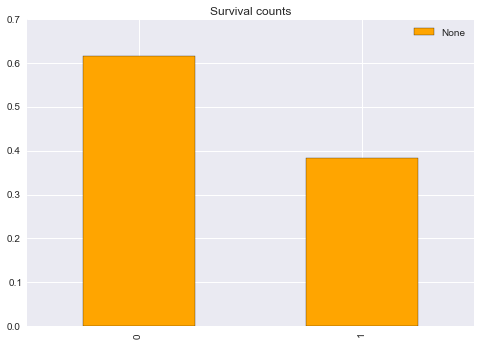

In [80]:
# normalising to get percentages
train.Survived.value_counts(normalize=True).plot(kind='bar',
                                  title="Survival counts",
                                  color='orange',
                                  align='center')

**TO DO** - get the y-ticks working in order to display %s accurately. Also, rename x-axis to Survived and Didn't survive. 

**2. How many people in different classes? and how did their survival chances differ?**

(array([  54.,   46.,  177.,  346.,  118.,   70.,   45.,   24.,    9.,    2.]),
 array([  0.42 ,   8.378,  16.336,  24.294,  32.252,  40.21 ,  48.168,
         56.126,  64.084,  72.042,  80.   ]),
 <a list of 10 Patch objects>)

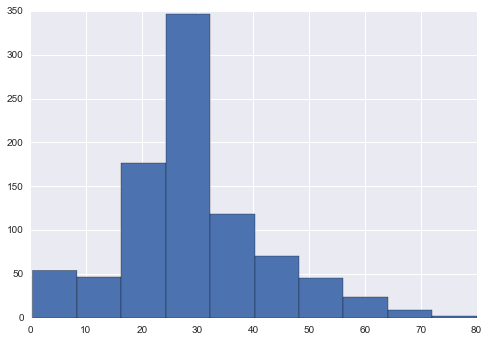

In [63]:
# age distribution
plt.hist(train['Age'],bins=10,range = (train['Age'].min(),train['Age'].max()))

most of the people seem to be young adults.

(array([ 562.,  170.,   67.,   39.,   15.,   16.,    2.,    0.,    9.,
           2.,    6.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    3.]),
 array([   0.     ,   25.61646,   51.23292,   76.84938,  102.46584,
         128.0823 ,  153.69876,  179.31522,  204.93168,  230.54814,
         256.1646 ,  281.78106,  307.39752,  333.01398,  358.63044,
         384.2469 ,  409.86336,  435.47982,  461.09628,  486.71274,
         512.3292 ]),
 <a list of 20 Patch objects>)

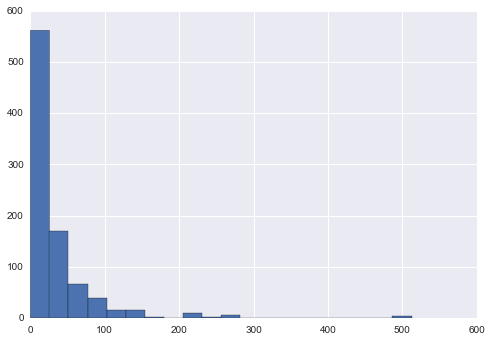

In [64]:
plt.hist(train['Fare'],bins=20)

seems like most of the fares are less than 100. but there are a few outliers that are pretty expensive. worth splitting the fares up by 100 and looking at the fare distribution.

(array([ 15.,   7.,   9.,   2.,   0.,   5.,   4.,   8.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([ 100.     ,  120.61646,  141.23292,  161.84938,  182.46584,
         203.0823 ,  223.69876,  244.31522,  264.93168,  285.54814,
         306.1646 ,  326.78106,  347.39752,  368.01398,  388.63044,
         409.2469 ,  429.86336,  450.47982,  471.09628,  491.71274,
         512.3292 ]),
 <a list of 20 Patch objects>)

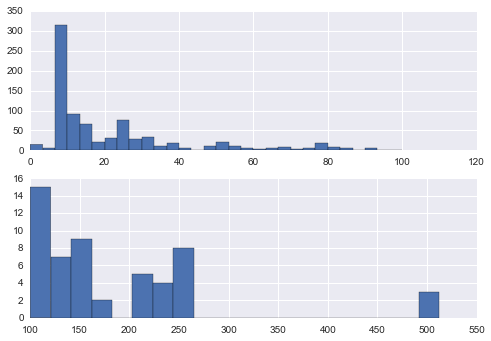

In [67]:
plt.subplot(211)
plt.hist(train['Fare'],bins=30,range=(train['Fare'].min(),100))
plt.subplot(212)
plt.hist(train['Fare'],bins=20,range=(100,train['Fare'].max()))

so we can see one clear outlier at \$500 but otherwise, it seems like the first class passengers paid in the 100-250 range, while the few second class people are between the 20-40 range. most of the 300-400 odd passengers seem to have paid around \$10 and they are probably in third class. Let's test these out by introducing class as well.

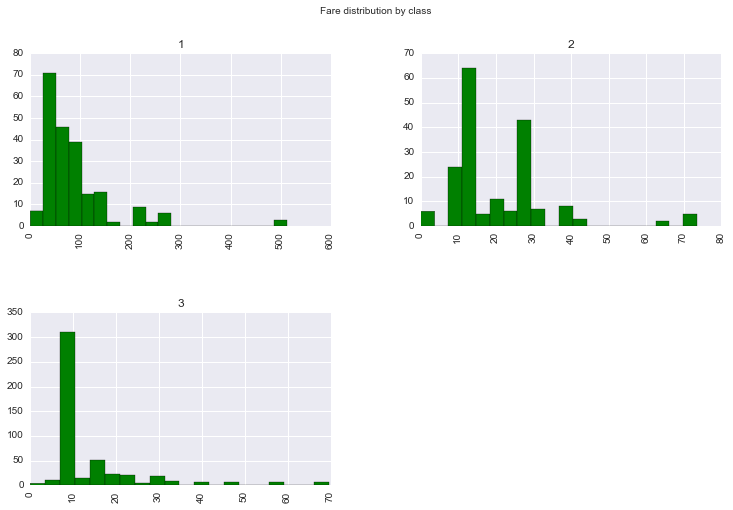

In [68]:
#plt.plot(x=train['Fare'],y=train['Pclass'])
#plt.hist([train['Fare'],train['Pclass']],normed=True,bins=30)
#plt.hist?
#from pandas import DataFrame
df = pd.DataFrame({'Pclass':train['Pclass'], 'Fare':train['Fare']})
df['Fare'].hist(by=df['Pclass'],color='green',figsize=(12,8),bins=20)
plt.suptitle("Fare distribution by class")

Interesting visualisation from a learnings perspective. First, a look into the actual graphs. And second, into what I learned about python.
- 1) Insights were correct about fares being tightly linked to class. third class passengers are mainly \$10, while second class varies between 10-40. First class varies between 50-120, with each having a few outliers. Presence of \$0 tickets indicates free rides or data entry issues.
- 2) i used pandas for this because it has a really good "group by" feature. matplotlib allows you to input multiple data in its "x" variable as a n dimensional array, but the viz is pretty terrible. check how the pandas dataframe stacks up against the R dataframe.

Let's see another way of seeing this in one figure - as a boxplot

OrderedDict([('Fare', <matplotlib.axes._subplots.AxesSubplot object at 0x000000001922A748>)])

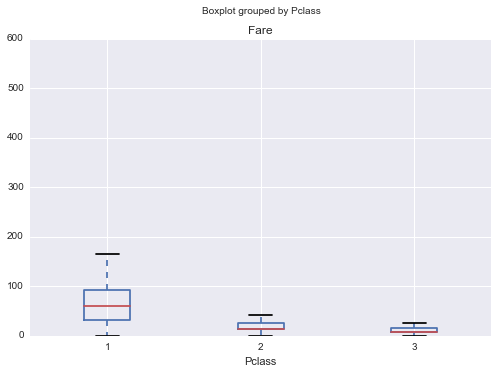

In [69]:
df.boxplot(column='Fare',return_type='axes',by='Pclass')
#df.boxplot?

### Quick look at categorical variables

Name, Sex, cabin, ticket, embarked.

In [70]:

temp1 = train.groupby('Pclass').Survived.count()
temp2 = train.groupby('Pclass').Survived.sum()/train.groupby('Pclass').Survived.count()

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Pclass')
ax1.set_ylabel('Count of Passengers')
ax1.set_title("Passengers by Pclass")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
temp2.plot(kind = 'bar')
ax2.set_xlabel('Pclass')
ax2.set_ylabel('Probability of Survival')
ax2.set_title("Probability of survival by class")

TypeError: Categorical cannot perform the operation sum

## Predicting survival